# Libraries

In [ ]:
!pip install smote_variants==0.5.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.2/290.2 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 10.2 MB/s eta 0:00:00
  Created wheel for minisom: filename=MiniSom-2.3.1-py3-none-any.whl size=10588 sha256=ffaf2f84cea13d04fce5ab868b5450a5af68e2b5534250306b9e892b93aba1a4
  Stored in directory: /root/.cache/pip/wheels/c7/92/d2/33bbda5f86fd8830510b16aa98c8dd420129b5cb24248fd6db
  Created wheel for statistics: filename=statistics-1.0.3.5-py3-none-any.whl size=7436 sha256=c00077dcda2a3d18dba9045ab24d5e5401f19f8eb1b8d35e3e4478f1a92ef17f
  Stored in directory: /root/.cache/pip/wheels/59/bd/aa/41ad56fbb723d36e457b5be74feb992cdac2855a6999ba34a1
Successfully built minisom statistics


# Imports

In [ ]:
import torch
import numpy as np
import pandas as pd
from time import time
import torch.nn as nn
from tqdm import tqdm
import tensorflow as tf
import torch.optim as optim
#import smote_variants as sv
from google.colab import drive
from collections import Counter
from keras.optimizers import Adam
from keras.metrics import Accuracy
from keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.layers import Embedding
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from torchvision.models import shufflenet_v2_x1_0
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models, metrics
from torch.utils.data import DataLoader, TensorDataset
from keras.layers import Dense, BatchNormalization, Input
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy, Precision, Recall
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Activation, GlobalAveragePooling1D, Add, LSTM, SeparableConv1D
from tensorflow.keras.layers import Conv1D, SpatialDropout1D, concatenate,Flatten, UpSampling1D, MaxPooling1D, Concatenate
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model

# Read file

In [ ]:
#Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Read the data from csv file
data = pd.read_csv('/content/drive/MyDrive/diabetes_prediction_dataset_100001_9.csv')

# Preprocess

In [ ]:
# Display a concise summary of the DataFrame, including data types and non-null counts
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


In [ ]:
data.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0


In [ ]:
# Check missing values
data.isnull().sum() 

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64

In [ ]:
# Check the data types of columns
data_types = data.dtypes

# Print the data types
print(data_types)

gender                  object
age                    float64
hypertension             int64
heart_disease            int64
smoking_history         object
bmi                    float64
HbA1c_level            float64
blood_glucose_level      int64
diabetes                 int64
dtype: object


In [ ]:
# Convert object column to int64
data['gender'] = pd.factorize(data.gender)[0]
data['smoking_history'] = pd.factorize(data.smoking_history)[0]

In [ ]:
# Check the data types of columns
data_types = data.dtypes

# Print the data types
print(data_types)

gender                   int64
age                    float64
hypertension             int64
heart_disease            int64
smoking_history          int64
bmi                    float64
HbA1c_level            float64
blood_glucose_level      int64
diabetes                 int64
dtype: object


In [ ]:
data.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,0,80.0,0,1,0,25.19,6.6,140,0
1,0,54.0,0,0,1,27.32,6.6,80,0
2,1,28.0,0,0,0,27.32,5.7,158,0
3,0,36.0,0,0,2,23.45,5.0,155,0
4,1,76.0,1,1,2,20.14,4.8,155,0


In [ ]:
# Get the dimensions of 'data'
data.shape

(100000, 9)

In [ ]:
X = data.drop('diabetes', axis=1)  # select all columns except 'target'
y = data['diabetes']                # select only the 'target' column

#X = data.iloc[:10000, :-1]  # Select the first 2000 rows for features (excluding the last column)
#y = data.iloc[:10000, -1]   # Extract the 'diabetes' column (last column) for labels


In [ ]:
# Encode string labels to numeric values
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Convert to integers
y = y_encoded.astype(int)

In [ ]:
# Get the count of values of each class in the 'diabetes' column 
data.value_counts("diabetes")

diabetes
0    91500
1     8500
dtype: int64

# ProWSyn

In [ ]:
import smote_variants as sv

# Convert X and y to numpy arrays
x_np = np.array(X)
y_np = np.array(y)

# Apply ProWSyn oversampling technique
oversampler_ProWSyn = sv.ProWSyn(random_state=2)
x_resampled, y_resampled = oversampler_ProWSyn.sample(x_np, y_np)

# Get the count of each class after oversampling
class_counts = Counter(y_resampled)
print(class_counts)

# Get the original class distribution in the 'diabetes' column
print(data.value_counts("diabetes"))


2023-10-15 11:44:13,946:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': 2}")
INFO:smote_variants:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': 2}")
2023-10-15 11:44:13,956:INFO:NearestNeighborsWithMetricTensor: NN fitting with metric minkowski
INFO:smote_variants:NearestNeighborsWithMetricTensor: NN fitting with metric minkowski
2023-10-15 11:44:13,968:INFO:NearestNeighborsWithMetricTensor: kneighbors query minkowski
INFO:smote_variants:NearestNeighborsWithMetricTensor: kneighbors query minkowski
2023-10-15 11:44:14,656:INFO:NearestNeighborsWithMetricTensor: NN fitting with metric minkowski
INFO:smote_variants:NearestNeighborsWithMetricTensor: NN fitting with metric minkowski
2023-10-15 11:44:14,665:INFO:NearestNeighborsWithMetricTensor: kneighbors query minkowski
INFO:smote_varia

Counter({0: 91500, 1: 91500})
diabetes
0    91500
1     8500
dtype: int64


# Split Train, Test

In [ ]:
# Split the original unbalanced data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Split the balanced data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(x_resampled, y_resampled, test_size=0.2, random_state=42)
df_shape = x_resampled

# Normalize Dataset 

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Assuming 'X' is your dataset as a numpy array
# Create an instance of the MinMaxScaler
scaler = MinMaxScaler()
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

# Fit the scaler to the data and transform the data
X_train = scaler.fit_transform(X_train)
y_train = scaler.fit_transform(y_train)
X_test = scaler.fit_transform(X_test)
y_test = scaler.fit_transform(y_test)


# Epoch

In [ ]:
# Set the number of training epochs
epoch = 30

# DBN

In [ ]:
# Record the start time of execution
start = time()

# Function to create a Deep Belief Network (DBN) model
def create_dbn(input_dim):
    model = Sequential()
    model.add(GaussianNoise(0.05, input_shape=(input_dim,)))  # Add Gaussian noise for regularization
    model.add(Dense(512, activation='relu'))  # First hidden layer
    model.add(Dropout(0.5))  # Dropout for regularization
    model.add(Dense(256, activation='relu'))  # Second hidden layer
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='tanh'))  # Third hidden layer
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='tanh'))  # Fourth hidden layer
    model.add(Dropout(0.5))
    model.add(Dense(32, activation='relu'))  # Fifth hidden layer
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='relu'))  # Output layer
    return model

# Create DBN model using training data dimensions
dbn_model = create_dbn(X_train.shape[1])

# Compile the model with Adam optimizer and binary cross-entropy loss
dbn_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Modify labels for compatibility with the model (one-hot encoding)
y_train_modified = np.concatenate((1 - y_train, y_train), axis=1)
y_test_modified = np.concatenate((1 - y_test, y_test), axis=1)

# Train the DBN model on the training set
dbn_model.fit(X_train, y_train_modified, epochs=epoch, batch_size=256)

# Predict probabilities on the test set
y_pred_probs = dbn_model.predict(X_test)
y_pred = np.where(y_pred_probs > 0.5, 1, 0)  # Convert probabilities to binary predictions
y_pred = np.argmax(y_pred, axis=1)  # Convert one-hot encoded predictions back to a single column
y_test_modified = np.argmax(y_test_modified, axis=1)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test_modified, y_pred)
precision = precision_score(y_test_modified, y_pred)
recall = recall_score(y_test_modified, y_pred)
f1 = f1_score(y_test_modified, y_pred)

# Print the evaluation metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

# Record the end time of execution
end = time()

# Calculate the execution time
execution_time = end - start  
print("Execution time:", execution_time)

Epoch 1/30
572/572 [==============================] - 5s 4ms/step - loss: 0.8773 - accuracy: 0.7666
Epoch 2/30
572/572 [==============================] - 2s 4ms/step - loss: 0.5293 - accuracy: 0.8317
Epoch 3/30
572/572 [==============================] - 2s 4ms/step - loss: 0.5014 - accuracy: 0.8348
Epoch 4/30
572/572 [==============================] - 3s 6ms/step - loss: 0.4901 - accuracy: 0.8335
Epoch 5/30
572/572 [==============================] - 3s 4ms/step - loss: 0.4734 - accuracy: 0.8347
Epoch 6/30
572/572 [==============================] - 2s 4ms/step - loss: 0.4594 - accuracy: 0.8475
Epoch 7/30
572/572 [==============================] - 2s 4ms/step - loss: 0.4565 - accuracy: 0.8279
Epoch 8/30
572/572 [==============================] - 2s 4ms/step - loss: 0.4427 - accuracy: 0.8429
Epoch 9/30
572/572 [==============================] - 3s 6ms/step - loss: 0.4348 - accuracy: 0.8316
Epoch 10/30
572/572 [==============================] - 3s 5ms/step - loss: 0.3942 - accuracy: 0.8602

# ResNet

In [ ]:
from tensorflow.keras.layers import SeparableConv1D

# Function to create a ResNet block with two SeparableConv1D layers
def resnet_block(inputs, num_filters, kernel_size=3, strides=1):
    x = inputs

    # First SeparableConv1D layer with ReLU activation
    x = SeparableConv1D(filters=num_filters, kernel_size=kernel_size, strides=strides, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Second SeparableConv1D layer
    x = SeparableConv1D(filters=num_filters, kernel_size=kernel_size, padding='same')(x)
    x = BatchNormalization()(x)

    # If input shape doesn't match, adjust the shortcut connection
    if inputs.shape[-1] != num_filters or strides != 1:
        shortcut = SeparableConv1D(filters=num_filters, kernel_size=1, strides=strides, padding='same')(inputs)
        shortcut = BatchNormalization()(shortcut)
    else:
        shortcut = inputs

    # Add the shortcut (residual connection) and apply activation
    x = Add()([x, shortcut])
    x = Activation('tanh')(x)

    return x

# Function to create a simple 1D ResNet model
def simple_resnet_1d(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # Initial SeparableConv1D layer
    x = SeparableConv1D(filters=64, kernel_size=3, strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('tanh')(x)

    # Adding residual blocks
    x = resnet_block(x, num_filters=16, strides=1)
    x = resnet_block(x, num_filters=8, strides=2)

    # Global average pooling followed by classification layer
    x = GlobalAveragePooling1D()(x)
    outputs = Dense(num_classes, activation='tanh')(x)

    # Build the model
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Define input shape and number of output classes
input_shape = (X_train.shape[1], 1)  # Assuming 1D input data
num_classes = 1  # For binary classification

# Record the start time of execution
start_time = time() 

# Create the model
model = simple_resnet_1d(input_shape, num_classes)

# Compile the model with Adam optimizer and binary crossentropy loss
learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model using the training data
model.fit(X_train, y_train, epochs=epoch, batch_size=256, validation_data=(X_test, y_test))

# Predict class probabilities on the test data
y_pred = model.predict(X_test)

# Convert probabilities to binary predictions (1 or 0)
y_pred = (y_pred > 0.5).astype(int)
y_pred_classes = np.argmax(y_pred, axis=1)  # Assuming binary classification

# Evaluate the model's performance using various metrics
res_accuracy = accuracy_score(y_test, y_pred)
res_precision = precision_score(y_test, y_pred)
res_recall = recall_score(y_test, y_pred)
res_f1 = f1_score(y_test, y_pred)

# Print the evaluation results
print(f"Accuracy: {res_accuracy}")
print(f"F1-score: {res_f1}")
print(f"Precision: {res_precision}")
print(f"Recall: {res_recall}")

# Record the end time and calculate execution duration
end_time = time()
res_execution_time = end_time - start_time
print("Execution time:", res_execution_time)


Epoch 1/30
572/572 [==============================] - 15s 14ms/step - loss: 1.3135 - accuracy: 0.6867 - val_loss: 1.4403 - val_accuracy: 0.6828
Epoch 2/30
572/572 [==============================] - 7s 12ms/step - loss: 0.4403 - accuracy: 0.8030 - val_loss: 0.4463 - val_accuracy: 0.8242
Epoch 3/30
572/572 [==============================] - 7s 13ms/step - loss: 0.3866 - accuracy: 0.8330 - val_loss: 0.4084 - val_accuracy: 0.7620
Epoch 4/30
572/572 [==============================] - 12s 21ms/step - loss: 0.3512 - accuracy: 0.8509 - val_loss: 0.3253 - val_accuracy: 0.8604
Epoch 5/30
572/572 [==============================] - 11s 18ms/step - loss: 0.9760 - accuracy: 0.7372 - val_loss: 1.1646 - val_accuracy: 0.6590
Epoch 6/30
572/572 [==============================] - 11s 18ms/step - loss: 0.9219 - accuracy: 0.7226 - val_loss: 0.6807 - val_accuracy: 0.7528
Epoch 7/30
572/572 [==============================] - 10s 17ms/step - loss: 0.4797 - accuracy: 0.7872 - val_loss: 0.4345 - val_accuracy: 0

# DHM-2 Hybrid (DBN_ResNet)

In [ ]:
start_time = time()  # Record the start time of execution

from tensorflow.keras.layers import SeparableConv1D

# Function to create a ResNet block with two SeparableConv1D layers
def resnet_block(inputs, num_filters, kernel_size=3, strides=1):
    x = inputs

    # First SeparableConv1D layer with ReLU activation
    x = SeparableConv1D(filters=num_filters, kernel_size=kernel_size, strides=strides, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Second SeparableConv1D layer
    x = SeparableConv1D(filters=num_filters, kernel_size=kernel_size, padding='same')(x)
    x = BatchNormalization()(x)

    # If input shape doesn't match, adjust the shortcut connection
    if inputs.shape[-1] != num_filters or strides != 1:
        shortcut = SeparableConv1D(filters=num_filters, kernel_size=1, strides=strides, padding='same')(inputs)
        shortcut = BatchNormalization()(shortcut)
    else:
        shortcut = inputs

    # Add the shortcut (residual connection) and apply activation
    x = Add()([x, shortcut])
    x = Activation('tanh')(x)

    return x

# Function to create a simple 1D ResNet model
def simple_resnet_1d(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # Initial SeparableConv1D layer
    x = SeparableConv1D(filters=64, kernel_size=3, strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('tanh')(x)

    # Adding residual blocks
    x = resnet_block(x, num_filters=16, strides=1)
    x = resnet_block(x, num_filters=8, strides=2)

    # Global average pooling followed by classification layer
    x = GlobalAveragePooling1D()(x)
    outputs = Dense(num_classes, activation='tanh')(x)

    # Build the model
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Define input shape and number of output classes
input_shape = (X_train.shape[1], 1)  # Assuming 1D input data
num_classes = 1  # For binary classification

# Create the model
model = simple_resnet_1d(input_shape, num_classes)

# Compile the model with Adam optimizer and binary crossentropy loss
learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model using the training data
model.fit(X_train, y_train, epochs=epoch, batch_size=256, validation_data=(X_test, y_test))

# Predict class probabilities on the test data
y_pred = model.predict(X_test)

# Convert probabilities to binary predictions (1 or 0)
y_pred = (y_pred > 0.5).astype(int)
y_pred_classes = np.argmax(y_pred, axis=1)  # Assuming binary classification

# Evaluate the model's performance using various metrics
res_accuracy = accuracy_score(y_test, y_pred)
res_precision = precision_score(y_test, y_pred)
res_recall = recall_score(y_test, y_pred)
res_f1 = f1_score(y_test, y_pred)

# Print the evaluation results
print(f"Accuracy: {res_accuracy}")
print(f"F1-score: {res_f1}")
print(f"Precision: {res_precision}")
print(f"Recall: {res_recall}")

# Record the end time and calculate execution duration
end_time = time()
res_execution_time = end_time - start_time
print("Execution time:", res_execution_time)


Epoch 1/30
572/572 [==============================] - 13s 10ms/step - loss: 0.3340 - accuracy: 0.8594
Epoch 2/30
572/572 [==============================] - 7s 11ms/step - loss: 0.2450 - accuracy: 0.8956
Epoch 3/30
572/572 [==============================] - 5s 10ms/step - loss: 0.2252 - accuracy: 0.9003
Epoch 4/30
572/572 [==============================] - 7s 11ms/step - loss: 0.2185 - accuracy: 0.9006
Epoch 5/30
572/572 [==============================] - 5s 10ms/step - loss: 0.2112 - accuracy: 0.9035
Epoch 6/30
572/572 [==============================] - 6s 11ms/step - loss: 0.2090 - accuracy: 0.9033
Epoch 7/30
572/572 [==============================] - 6s 10ms/step - loss: 0.2060 - accuracy: 0.9040
Epoch 8/30
572/572 [==============================] - 6s 10ms/step - loss: 0.2043 - accuracy: 0.9057
Epoch 9/30
572/572 [==============================] - 6s 11ms/step - loss: 0.2040 - accuracy: 0.9050
Epoch 10/30
572/572 [==============================] - 5s 9ms/step - loss: 0.2001 - accura

# 10-fold cross validation DHM_2

In [ ]:
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.layers import GaussianNoise

# Function to create DBN (Deep Belief Network) model
def create_dbn(input_dim, output_shape=(8, 1)):
    model = Sequential()
    model.add(GaussianNoise(0.05, input_shape=(input_dim,)))  # Add Gaussian noise for regularization
    model.add(Dense(512, activation='relu'))  # First hidden layer
    model.add(Dropout(0.5))  # Dropout for regularization
    model.add(Dense(256, activation='relu'))  # Second hidden layer
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='tanh'))  # Third hidden layer
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='tanh'))  # Fourth hidden layer
    model.add(Dropout(0.5))
    model.add(Dense(32, activation='relu'))  # Fifth hidden layer
    model.add(Dropout(0.5))
    model.add(Dense(np.prod(output_shape), activation='relu'))  # Output layer
    model.add(Reshape(output_shape))  # Reshape the output for further use
    return model

# Function to create a ResNet block for 1D inputs
def resnet_block(inputs, num_filters, kernel_size=3, strides=1):
    x = inputs
    x = SeparableConv1D(filters=num_filters, kernel_size=kernel_size, strides=strides, padding='same')(x)  # First conv layer
    x = BatchNormalization()(x)  # Batch normalization
    x = Activation('relu')(x)  # ReLU activation
    x = SeparableConv1D(filters=num_filters, kernel_size=kernel_size, padding='same')(x)  # Second conv layer
    x = BatchNormalization()(x)

    # Adjusting shortcut connection if the input shape is different
    if inputs.shape[-1] != num_filters or strides != 1:
        shortcut = SeparableConv1D(filters=num_filters, kernel_size=1, strides=strides, padding='same')(inputs)
        shortcut = BatchNormalization()(shortcut)
    else:
        shortcut = inputs

    x = Add()([x, shortcut])  # Add residual connection
    x = Activation('relu')(x)  # ReLU activation after residual connection

    return x

# Function to create a simple ResNet for 1D data
def simple_resnet_1d(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = SeparableConv1D(filters=32, kernel_size=3, strides=2, padding='same')(inputs)  # Initial convolution
    x = BatchNormalization()(x)
    x = Activation('tanh')(x)  # Activation layer
    x = resnet_block(x, num_filters=8, strides=1)  # ResNet block
    x = GlobalAveragePooling1D()(x)  # Global pooling
    outputs = Dense(8, activation='tanh')(x)  # Output dense layer
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Define the number of folds for Stratified K-Fold cross-validation
num_folds = 10

# Lists to store evaluation metrics for each fold
accuracy_scores = []
f1_scores = []
precision_scores = []
recall_scores = []
execution_times = []

# Create a StratifiedKFold object for splitting the data
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Loop through each fold for cross-validation
for fold, (train_index, test_index) in enumerate(skf.split(X_train, y_train)):
    X_train_fold, X_test_fold = X_train[train_index], X_train[test_index]
    y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]

    # Define input dimensions and number of classes for the model
    input_dim = X_train.shape[1]
    num_classes = 1

    # Create the hybrid model by combining DBN and ResNet
    hybrid_model = Sequential()
    hybrid_model.add(create_dbn(input_dim))  # Add DBN component
    hybrid_model.add(simple_resnet_1d((input_dim,1), num_classes))  # Add ResNet component

    # Add dense layer for binary classification
    hybrid_model.add(Dense(1, activation='sigmoid'))

    # Compile the hybrid model
    hybrid_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

    # Train the hybrid model
    start_time = time()
    hybrid_model.fit(X_train_fold, y_train_fold, epochs=30, batch_size=256)  # Training parameters
    end_time = time()
    execution_times.append(end_time - start_time)

    # Evaluate the hybrid model on the test set of the fold
    y_pred_fold = hybrid_model.predict(X_test_fold)
    y_pred_fold = np.round(y_pred_fold).astype(int)  # Convert probabilities to binary predictions

    # Calculate evaluation metrics for the fold
    accuracy_fold = accuracy_score(y_test_fold, y_pred_fold)
    f1_fold = f1_score(y_test_fold, y_pred_fold)
    precision_fold = precision_score(y_test_fold, y_pred_fold, zero_division=1)
    recall_fold = recall_score(y_test_fold, y_pred_fold)

    # Print fold-specific metrics
    print(f"Fold {fold + 1} - Accuracy: {accuracy_fold:.4f}, F1 Score: {f1_fold:.4f}, Precision: {precision_fold:.4f}, Recall: {recall_fold:.4f}, Execution Time: {end_time - start_time:.2f} seconds")

    # Store the metrics for each fold
    accuracy_scores.append(accuracy_fold)
    f1_scores.append(f1_fold)
    precision_scores.append(precision_fold)
    recall_scores.append(recall_fold)

# Calculate and print the average metrics across all folds
avg_accuracy = np.mean(accuracy_scores)
avg_f1 = np.mean(f1_scores)
avg_precision = np.mean(precision_scores)
avg_recall = np.mean(recall_scores)
avg_exec_time = np.mean(execution_times)

print("\nAverage Metrics Across Folds:")
print("Average Accuracy:", avg_accuracy)
print("Average F1 Score:", avg_f1)
print("Average Precision:", avg_precision)
print("Average Recall:", avg_recall)
print("Average Execution Time: ", avg_exec_time)


Epoch 1/30
515/515 [==============================] - 15s 10ms/step - loss: 0.3225 - accuracy: 0.8613
Epoch 2/30
515/515 [==============================] - 5s 11ms/step - loss: 0.2424 - accuracy: 0.8954
Epoch 3/30
515/515 [==============================] - 5s 10ms/step - loss: 0.2255 - accuracy: 0.8989
Epoch 4/30
515/515 [==============================] - 5s 9ms/step - loss: 0.2162 - accuracy: 0.9013
Epoch 5/30
515/515 [==============================] - 6s 11ms/step - loss: 0.2116 - accuracy: 0.9026
Epoch 6/30
515/515 [==============================] - 5s 10ms/step - loss: 0.2071 - accuracy: 0.9038
Epoch 7/30
515/515 [==============================] - 7s 13ms/step - loss: 0.2062 - accuracy: 0.9050
Epoch 8/30
515/515 [==============================] - 5s 10ms/step - loss: 0.2020 - accuracy: 0.9065
Epoch 9/30
515/515 [==============================] - 5s 10ms/step - loss: 0.2006 - accuracy: 0.9055
Epoch 10/30
515/515 [==============================] - 6s 11ms/step - loss: 0.1993 - accura

# SHAP

In [ ]:
!pip install shap

In [ ]:
import shap
import tqdm
background_summary = shap.kmeans(X_train, 25)
model = hybrid_model
# Create SHAP explainer using KernelExplainer with summarized background data
with tqdm.tqdm(total=len(X_train)) as pbar:
    explainer = shap.KernelExplainer(model.predict, background_summary)
    pbar.update(len(X_train))

# Calculate SHAP values for the test set
with tqdm.tqdm(total=len(X_test)) as pbar:
    shap_values = explainer.shap_values(X_test)
    pbar.update(len(X_test))

  0%|          | 0/14625 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


  0%|          | 0/3657 [00:00<?, ?it/s]

  0%|          | 0/3657 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
199/199 [==============================] - 0s 2ms/step


100%|██████████| 3657/3657 [47:24<00:00,  1.29it/s]


## GRAPHS

In [ ]:
# Assuming 'shap_values' has a shape of (1, 728, 8)
shap_values = np.squeeze(shap_values)

# Now 'shap_values' will have a shape of (728, 8)
print(shap_values.shape)

(3657, 8)


### Summary

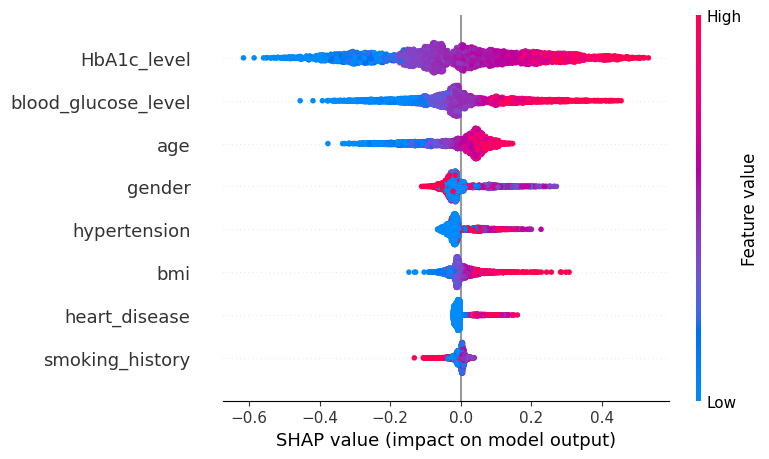

In [ ]:
import matplotlib.pyplot as plt

shap.summary_plot(shap_values,X_test,feature_names=X.columns)

# Save the plot to a file
plt.savefig('Summary_plot.png')  # You can change the filename and extension as needed
plt.close()  # Close the plot to free up resources

### waterfall

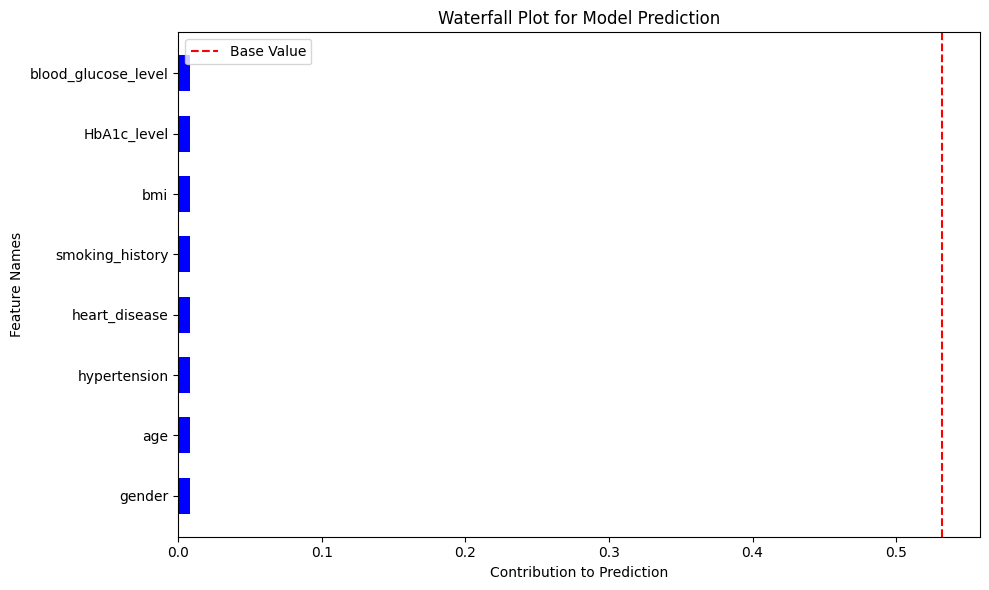

In [ ]:
instance_index = 0

# Assuming your model is a single-output model
model_output_index = 0

# Calculate the base value for the specific model output
base_value = explainer.expected_value[model_output_index]

# Calculate the contribution of each feature for the selected instance
instance_contributions = shap_values[model_output_index][instance_index]

# Get the names of the features
feature_names = X.columns

# Calculate the cumulative contributions
cumulative_contributions = np.cumsum(instance_contributions)

# Create the waterfall plot
plt.figure(figsize=(10, 6))
plt.barh(feature_names, cumulative_contributions, color='b', height=0.6, align='center')
plt.axvline(x=base_value, color='red', linestyle='--', linewidth=1.5, label='Base Value')
plt.xlabel('Contribution to Prediction')
plt.ylabel('Feature Names')
plt.title('Waterfall Plot for Model Prediction')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()


### HeatMap

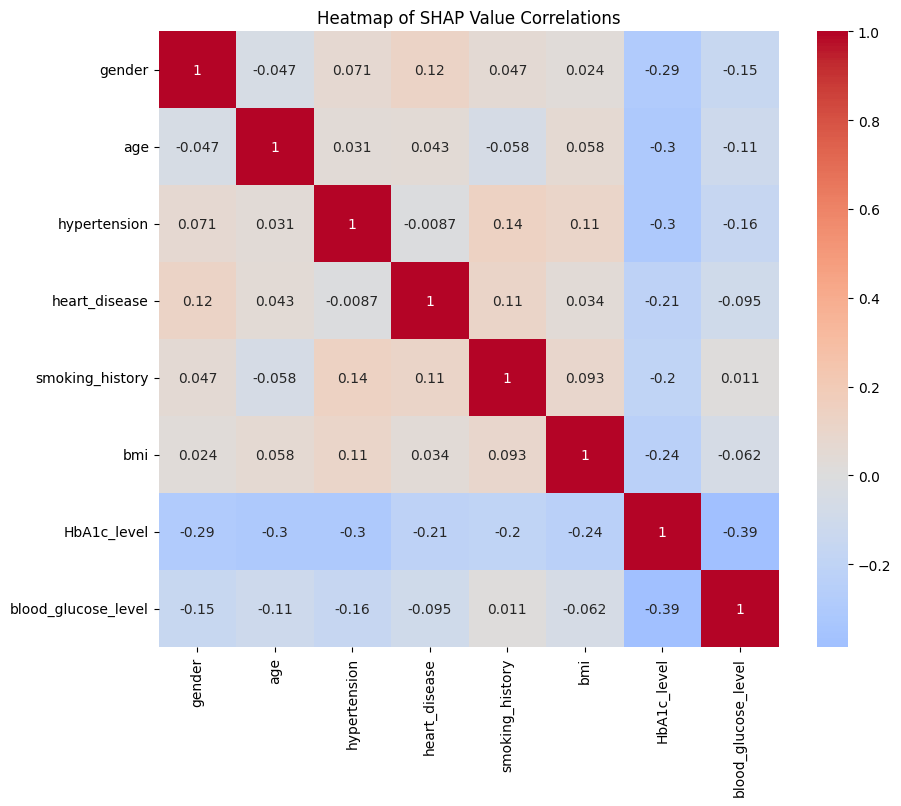

In [ ]:
import shap
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have your SHAP values calculated and stored in shap_values
# Assuming you have your feature values in X (as a DataFrame)

# Initialize the SHAP visualization
shap.initjs()

# Get the absolute SHAP values for each feature (you can use other aggregation functions as well)
shap_abs = pd.DataFrame(np.abs(shap_values), columns=X.columns)

# Calculate the correlation matrix based on SHAP values
correlation_matrix = shap_abs.corr()

# Create the Heatmap Plot using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Heatmap of SHAP Value Correlations')
plt.show()

# Save the plot to a file
plt.savefig('HeatMap.png')  # You can change the filename and extension as needed
plt.close()  # Close the plot to free up resources

### Bar Plot

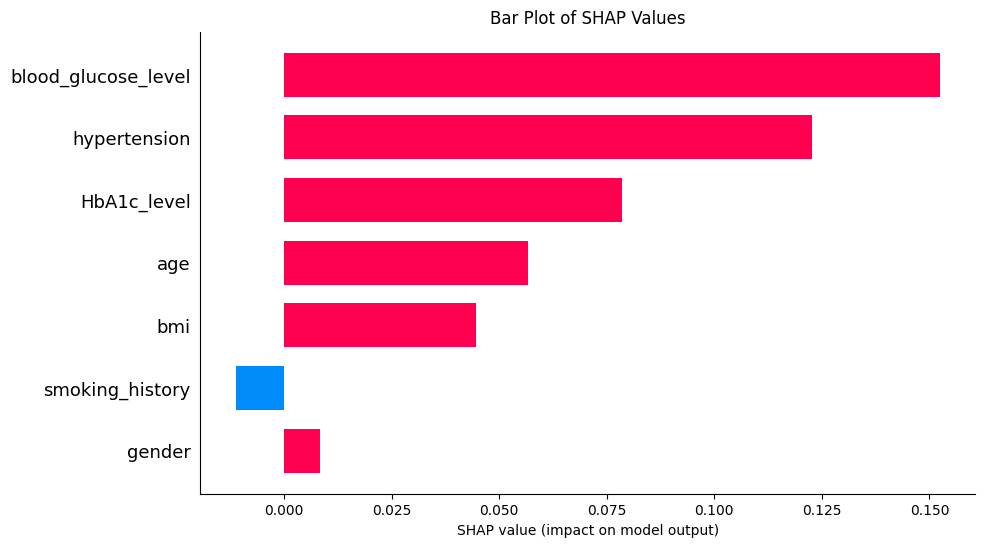

In [ ]:
import shap
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have your SHAP values calculated and stored in shap_values
# Assuming you have your feature values for the instance you want to visualize in X_instance (as a DataFrame)

# Initialize the SHAP visualization
shap.initjs()

# Choose the index of the instance for which you want to create the Bar Plot
instance_index = 0  # Replace with the index of the instance you want to visualize

# Create the Bar Plot
plt.figure(figsize=(10, 6))
shap.bar_plot(shap_values[instance_index], feature_names=X.columns, show=False)
plt.title('Bar Plot of SHAP Values')
plt.show()

# Save the plot to a file
plt.savefig('bar_plot.png')  # You can change the filename and extension as needed
plt.close()  # Close the plot to free up resources

<Figure size 1000x600 with 0 Axes>

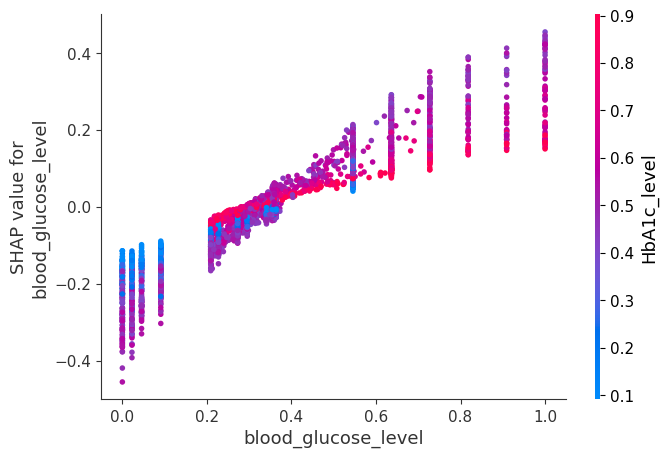

In [ ]:
# Choose an index for the instance you want to visualize
index_to_explain = 36

# Generate the force plot
plt.figure(figsize=(10, 6))
shap.dependence_plot("blood_glucose_level", shap_values, X_test, feature_names=X.columns)
plt.show()
# Show the plot (optional)
plt.show()
